# CNN Model Generation using different Techniques

## Introduction:

1. Build Convolutional Neural Network to classify CIFAR-10 Images.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example.
import keras
import numpy as np
from keras.datasets import cifar10


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels 

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implemented a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Applied the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
  labels_list = list(y)
  #array = np.zeros((len(y), dimensions))
  results_list = list(map(lambda y: [1 if i == y else 0 for i in range(10)], labels_list))
  results = np.array(results_list)
  return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)


#### Remark: the outputs is 
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets 

Randomly partitioned the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :] 

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


## 2. Built a CNN and tune its hyper-parameters 

- Built a convolutional neural network model using the below structure:

- It has a structure of: Conv - ReLU - Max Pool - ConV - ReLU - Max Pool - Dense - ReLU - Dense - Softmax

- In the graph 3@32x32 means the dimension of input image, 32@30x30 means it has 32 filters and the dimension now becomes 30x30 after the convolution.
- All convolutional layers (Conv) should have stride = 1 and no padding.
- Max Pooling has a pool size of 2 by 2.




<img src="network.PNG"/>

- I have used the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Tried to achieve a validation accuracy as high as possible.

In [4]:
# Build the model
from keras import layers, models, optimizers
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(32,32,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(4,4), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [5]:
# Define model optimizer and loss function
#RMSprop with 1e-4, 0.001, 0.01
#Adadelta with 0.0001 , 0.001 , 0.01

model.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [6]:
# Train the model and store model parameters/loss values
history = model.fit(x_tr, y_tr, batch_size=100, epochs=50, validation_data=(x_val, y_val), validation_steps = 20)

Epoch 1/50
400/400 [==============================] - 6s 8ms/step - loss: 5.2736 - accuracy: 0.2813 - val_loss: 2.7698 - val_accuracy: 0.3310
Epoch 2/50
400/400 [==============================] - 3s 8ms/step - loss: 2.2136 - accuracy: 0.3947 - val_loss: 2.0042 - val_accuracy: 0.3975
Epoch 3/50
400/400 [==============================] - 3s 7ms/step - loss: 1.7112 - accuracy: 0.4541 - val_loss: 1.6953 - val_accuracy: 0.4615
Epoch 4/50
400/400 [==============================] - 4s 10ms/step - loss: 1.4744 - accuracy: 0.5062 - val_loss: 1.5715 - val_accuracy: 0.4805
Epoch 5/50
400/400 [==============================] - 3s 7ms/step - loss: 1.3168 - accuracy: 0.5512 - val_loss: 1.4177 - val_accuracy: 0.5300
Epoch 6/50
400/400 [==============================] - 3s 7ms/step - loss: 1.1917 - accuracy: 0.5888 - val_loss: 1.4128 - val_accuracy: 0.5355
Epoch 7/50
400/400 [==============================] - 2s 4ms/step - loss: 1.0880 - accuracy: 0.6235 - val_loss: 1.3655 - val_accuracy: 0.5500
Epoch

## 3. Plot the training and validation loss curve versus epochs. (5 points)

---



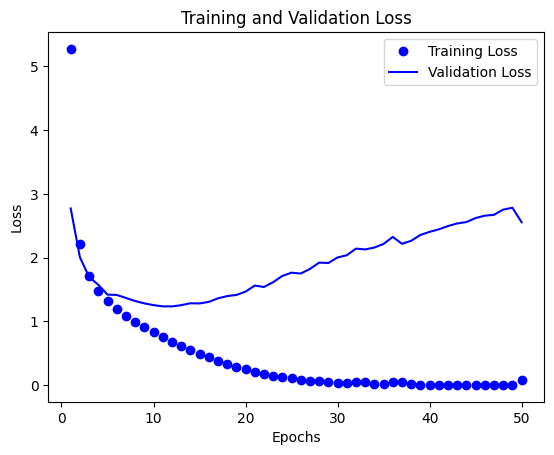

In [7]:
# Plot the loss curve
import matplotlib.pyplot as plt

# Extract the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 4. Train (again) and evaluate the model 

- To this end, I found the "best" hyper-parameters. 
- Now, fixed the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluated the model on the test set.

### Train the model on the entire training set

In [8]:
#<Compile the model again (using the same hyper-parameters you tuned above)>
model.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [9]:
#<Train the model on the entire training set (50K samples)>
history_train = model.fit(x_train, y_train_vec, batch_size =100, epochs=40)

Epoch 1/40
500/500 [==============================] - 3s 5ms/step - loss: 0.5072 - accuracy: 0.8889
Epoch 2/40
500/500 [==============================] - 2s 4ms/step - loss: 0.2855 - accuracy: 0.9307
Epoch 3/40
500/500 [==============================] - 2s 4ms/step - loss: 0.1854 - accuracy: 0.9514
Epoch 4/40
500/500 [==============================] - 2s 4ms/step - loss: 0.1215 - accuracy: 0.9682
Epoch 5/40
500/500 [==============================] - 2s 4ms/step - loss: 0.0782 - accuracy: 0.9793
Epoch 6/40
500/500 [==============================] - 2s 4ms/step - loss: 0.0534 - accuracy: 0.9874
Epoch 7/40
500/500 [==============================] - 2s 5ms/step - loss: 0.0345 - accuracy: 0.9930
Epoch 8/40
500/500 [==============================] - 2s 4ms/step - loss: 0.0288 - accuracy: 0.9942
Epoch 9/40
500/500 [==============================] - 2s 4ms/step - loss: 0.0302 - accuracy: 0.9932
Epoch 10/40
500/500 [==============================] - 2s 4ms/step - loss: 0.0303 - accuracy: 0.9928

## 5. Evaluate the model on the test set (5 points)

Do NOT use the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
# Evaluated your model performance (testing accuracy) on testing data.
accuracy = model.evaluate(x_test, y_test_vec)
print('Loss =' + str(round(accuracy[0],2)))
print('Accuracy =' + str(round(accuracy[1],2)))

313/313 [==============================] - 1s 3ms/step - loss: 3.1217 - accuracy: 0.6582
Loss =3.12
Accuracy =0.66


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

**Model** **1**

In [11]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32,(3,3), input_shape=(32,32,3)))
model1.add(layers.BatchNormalization()) #batch normalization 1
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64,(4,4)))
model1.add(layers.BatchNormalization()) #batch normalization 2
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256))
model1.add(layers.Dropout(0.5)) #dropout layer 1
model1.add(layers.BatchNormalization()) #batch normalization 3
model1.add(layers.Activation('relu'))
model1.add(layers.Dropout(0.5)) #dropout layer 2
model1.add(layers.BatchNormalization()) #batch normalization 4
model1.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [12]:
model1.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [13]:
history_model1 = model1.fit(x_tr, y_tr, batch_size=100, epochs=40, validation_data=(x_val, y_val), validation_steps = 20)

Epoch 1/40
400/400 [==============================] - 4s 7ms/step - loss: 2.1683 - accuracy: 0.2894 - val_loss: 1.5288 - val_accuracy: 0.4490
Epoch 2/40
400/400 [==============================] - 2s 6ms/step - loss: 1.7375 - accuracy: 0.3987 - val_loss: 1.3907 - val_accuracy: 0.5135
Epoch 3/40
400/400 [==============================] - 2s 6ms/step - loss: 1.5599 - accuracy: 0.4523 - val_loss: 1.2993 - val_accuracy: 0.5345
Epoch 4/40
400/400 [==============================] - 2s 6ms/step - loss: 1.4319 - accuracy: 0.4969 - val_loss: 1.2261 - val_accuracy: 0.5610
Epoch 5/40
400/400 [==============================] - 2s 6ms/step - loss: 1.3495 - accuracy: 0.5248 - val_loss: 1.2028 - val_accuracy: 0.5770
Epoch 6/40
400/400 [==============================] - 3s 6ms/step - loss: 1.2774 - accuracy: 0.5487 - val_loss: 1.1317 - val_accuracy: 0.6205
Epoch 7/40
400/400 [==============================] - 2s 5ms/step - loss: 1.2165 - accuracy: 0.5748 - val_loss: 1.0848 - val_accuracy: 0.6280
Epoch 

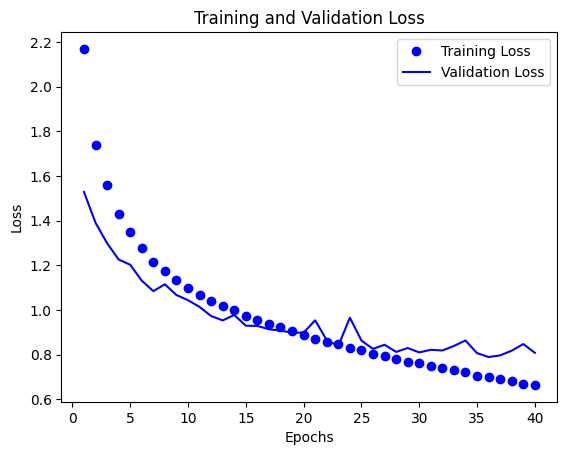

In [14]:
# Extract the training and validation loss values from the history object
train_loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

# Plot the training and validation loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

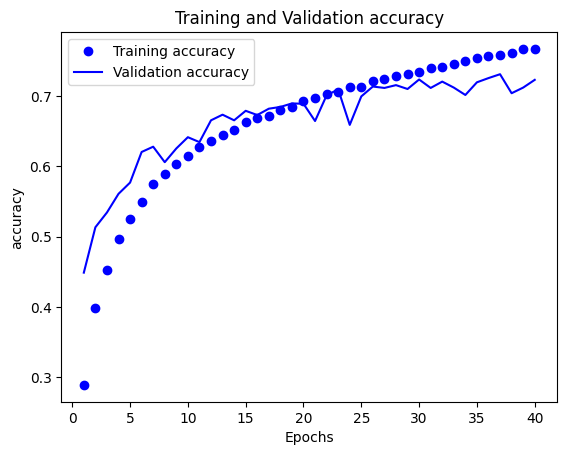

In [15]:
# Extract the training and validation accuracy values from the history object
train_accuracy = history_model1.history['accuracy']
val_accuracy = history_model1.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [16]:
model1.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [17]:
history_model1_train = model1.fit(x_train, y_train_vec, batch_size =128, epochs=40)

Epoch 1/40
391/391 [==============================] - 4s 7ms/step - loss: 0.7127 - accuracy: 0.7542
Epoch 2/40
391/391 [==============================] - 3s 7ms/step - loss: 0.7019 - accuracy: 0.7572
Epoch 3/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6852 - accuracy: 0.7607
Epoch 4/40
391/391 [==============================] - 3s 6ms/step - loss: 0.6735 - accuracy: 0.7649
Epoch 5/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6729 - accuracy: 0.7662
Epoch 6/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6637 - accuracy: 0.7698
Epoch 7/40
391/391 [==============================] - 3s 8ms/step - loss: 0.6506 - accuracy: 0.7754
Epoch 8/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6429 - accuracy: 0.7752
Epoch 9/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6344 - accuracy: 0.7796
Epoch 10/40
391/391 [==============================] - 3s 7ms/step - loss: 0.6251 - accuracy: 0.7820

In [18]:
accuracy = model1.evaluate(x_test, y_test_vec)
print('Loss =' + str(round(accuracy[0],2)))
print('Accuracy =' + str(round(accuracy[1],2)))

313/313 [==============================] - 1s 4ms/step - loss: 0.7724 - accuracy: 0.7398
Loss =0.77
Accuracy =0.74


**Model 2**

In [35]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3), input_shape=(32,32,3)))
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64,(4,4)))
model2.add(layers.BatchNormalization()) #batch normalization layers 1
model2.add(layers.Activation('relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(256))
model2.add(layers.Dropout(0.4)) #dropout layer 1
#model2.add(layers.BatchNormalization()) #batch normalization layers 2
model2.add(layers.Activation('relu'))
model2.add(layers.Dropout(0.5)) #dropout layer 2
#model2.add(layers.BatchNormalization()) #batch normalization layers 3
model2.add(layers.Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 64)        32832     
                                                                 
 batch_normalization_9 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 12, 12, 64)       

In [36]:
model2.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [37]:
history_train_2 = model2.fit(x_tr, y_tr, batch_size=100, epochs=40, validation_data=(x_val, y_val), validation_steps = 20)

Epoch 1/40
400/400 [==============================] - 3s 5ms/step - loss: 2.0330 - accuracy: 0.2752 - val_loss: 1.6919 - val_accuracy: 0.4195
Epoch 2/40
400/400 [==============================] - 2s 4ms/step - loss: 1.7050 - accuracy: 0.3850 - val_loss: 1.4725 - val_accuracy: 0.4850
Epoch 3/40
400/400 [==============================] - 2s 5ms/step - loss: 1.5572 - accuracy: 0.4405 - val_loss: 1.4549 - val_accuracy: 0.4740
Epoch 4/40
400/400 [==============================] - 2s 4ms/step - loss: 1.4539 - accuracy: 0.4796 - val_loss: 1.2890 - val_accuracy: 0.5420
Epoch 5/40
400/400 [==============================] - 2s 5ms/step - loss: 1.3828 - accuracy: 0.5062 - val_loss: 1.2769 - val_accuracy: 0.5380
Epoch 6/40
400/400 [==============================] - 2s 5ms/step - loss: 1.3256 - accuracy: 0.5311 - val_loss: 1.2313 - val_accuracy: 0.5685
Epoch 7/40
400/400 [==============================] - 2s 5ms/step - loss: 1.2751 - accuracy: 0.5495 - val_loss: 1.1541 - val_accuracy: 0.5810
Epoch 

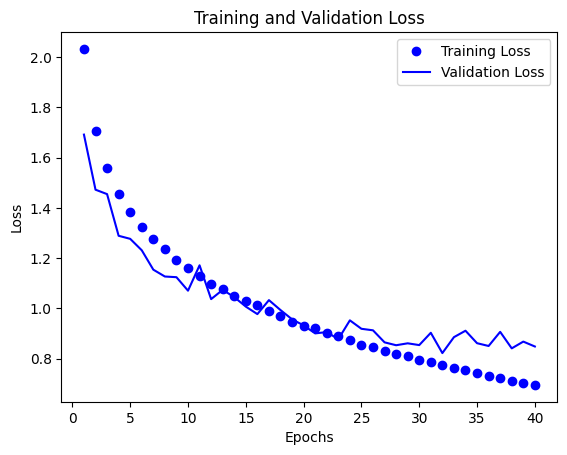

In [38]:
# Extract the training and validation loss values from the history object
train_loss = history_train_2.history['loss']
val_loss = history_train_2.history['val_loss']

# Plot the training and validation loss curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

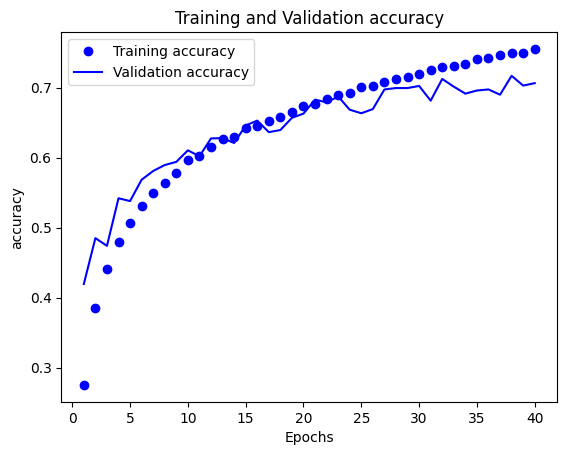

In [39]:
# Extract the training and validation accuracy values from the history object
train_accuracy = history_train_2.history['accuracy']
val_accuracy = history_train_2.history['val_accuracy']

# Plot the training and validation accuracy curves
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [40]:
model2.compile( optimizer = optimizers.Adam(learning_rate=0.0001), loss ='categorical_crossentropy', metrics=['accuracy'] )

In [41]:
history_model2_train = model2.fit(x_train, y_train_vec, batch_size =128, epochs=40)

Epoch 1/40
391/391 [==============================] - 3s 5ms/step - loss: 0.7455 - accuracy: 0.7419
Epoch 2/40
391/391 [==============================] - 2s 5ms/step - loss: 0.7347 - accuracy: 0.7434
Epoch 3/40
391/391 [==============================] - 2s 5ms/step - loss: 0.7189 - accuracy: 0.7512
Epoch 4/40
391/391 [==============================] - 2s 5ms/step - loss: 0.7095 - accuracy: 0.7530
Epoch 5/40
391/391 [==============================] - 2s 6ms/step - loss: 0.7022 - accuracy: 0.7555
Epoch 6/40
391/391 [==============================] - 2s 6ms/step - loss: 0.6875 - accuracy: 0.7598
Epoch 7/40
391/391 [==============================] - 2s 5ms/step - loss: 0.6819 - accuracy: 0.7615
Epoch 8/40
391/391 [==============================] - 2s 5ms/step - loss: 0.6753 - accuracy: 0.7608
Epoch 9/40
391/391 [==============================] - 2s 5ms/step - loss: 0.6689 - accuracy: 0.7641
Epoch 10/40
391/391 [==============================] - 2s 5ms/step - loss: 0.6590 - accuracy: 0.7688

In [42]:
accuracy = model2.evaluate(x_test, y_test_vec)
print('Loss =' + str(round(accuracy[0],2)))
print('Accuracy =' + str(round(accuracy[1],2)))

313/313 [==============================] - 1s 4ms/step - loss: 0.7890 - accuracy: 0.7475
Loss =0.79
Accuracy =0.75


For Actual Model, I used Adam as optimisers with learning rate of 0.0001. I was able to achieve 66% accuracy overall. \\
For Model 1, I used 4 batch normalization layer and 2 drop out layer with each drop out rate of 0.5. I achieved accuracy of 74%. \\
For Model 2, I used 3 batch normalization layer and 1 drop out layer with value of 0.4 and oth with value of 0.5. I achieved accuracy of 75% 
Also I have applied Data Augmentatio to improve accuracy above 80% and pretrained techniques to around 90%.